# Homogeneous implicit derivative (isotropic case)

Given a supercell matrix $\mathbf{C}\in \mathbb{R}^{3\times 3}$, we assume isotropic variations controlled by a homogeneous strain $\epsilon^*_\mathbf{\Theta}\in\mathbb{R}$ around a reference
supercell ${\bf C}_0$:
$$
\mathbf{C}^*_\mathbf{\Theta}=
\left[1+ \epsilon^*_\mathbf{\Theta}\right]\mathbf{C}_0
,\quad 
\nabla_\mathbf{\Theta}\mathbf{C}^*_{\mathbf{\Theta}}=(\nabla_\mathbf{\Theta} \epsilon^*_\mathbf{\Theta})\mathbf{C}_0,
$$

Then, the _homogeneous_ implicit derivative is $\nabla_\mathbf{\Theta} \epsilon^*_\mathbf{\Theta}\in\mathbb{R}^{N_D}$, also called `dStrain_dTheta` in the code.

In [1]:
# Standard libraries
import os
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

# Package imports
from lammps_implicit_der import SNAP, LammpsImplicitDer
from lammps_implicit_der.systems import BCC, BCC_BINARY, BCC_BINARY_VACANCY, BCC_VACANCY, \
                                        BCC_SIA, FromData, HCP, \
                                        BccVacancyConcentration
from lammps_implicit_der.tools import plot_tools

# No parallel MPI runs in the notebook, but keep comm for consistency
comm = None

# For parallel runs, use the following:
# from lammps_implicit_der.tools import mpi_print, initialize_mpi
# comm, rank = initialize_mpi()

## Create an atomic system. BCC vacancy as an example

First, with the non-perturbed potential $\bar{\mathbf{\Theta}}$

In [2]:
# System size affects the computational time, use ncell_x = 2 for quick test
ncell_x = 2
#ncell_x = 3

alat = 3.16316

vac0 = BCC_VACANCY(alat=alat, ncell_x=ncell_x, del_coord=[0.0, 0.0, 0.0],
                   snapcoeff_filename='W_REF.snapcoeff',
                   minimize=True, fix_box_relax=False,
                   logname='vac0.log', comm=comm, verbose=False)

# Initial values:
# Potential coefficients
Theta0 = vac0.pot.Theta_dict['W']['Theta'].copy()
# Positions
X_coord0 = vac0.X_coord.copy()
# Volume
volume0 = vac0.volume
# Supercell matrix
cell0 = vac0.cell.copy()

## Compute the homogeneous implicit derivative `dStrain_dTheta`

In [3]:
dStrain_dTheta = vac0.implicit_derivative_hom_iso()

## Predict the equilibrium volume change for an ensemble of potentials $\mathbf{\Theta}_m$

In [4]:
# Read the potential ensemble
with open('Theta_ens.pkl', 'rb') as f:
    Theta_ens = pickle.load(f)

# There are 100 samples in the ensmeble, we select only ten here for demonstration purpose
sample_list = np.arange(0, 10, 1)

volume_pred_list = []
volume_true_list = []

for sample in tqdm(sample_list):

    # Read the SNAP coefficients
    Theta_perturb = Theta_ens['Theta_ens_list'][sample]
    dTheta = Theta_perturb - Theta0

    # Predict the strain
    Strain_pred = dTheta @ dStrain_dTheta
    # Predict the supercell matrix
    cell_pred = cell0 @ (np.eye(3) * (1.0 + Strain_pred))
    # Predict the new equilibrium volume
    volume_pred = np.linalg.det(cell_pred)

    #
    # Next steps are for the true volume calculation from LAMMPS box relaxation
    #
    #  Create a SNAP object
    pot = SNAP.from_files('W_REF.snapcoeff', comm=comm)

    # Change the potential coefficients to the perturbed values
    pot.Theta_dict['W']['Theta'] = Theta_perturb

    # Save the perturbed potential coefficients
    pot.to_files(path='.',
                 snapcoeff_filename='W_perturb_new.snapcoeff', snapparam_filename='W_perturb_new.snapparam',
                 overwrite=True, verbose=False)

    # Create a perturbed LAMMPS system
    vac_perturb = BCC_VACANCY(alat=alat, ncell_x=ncell_x, del_coord=[0.0, 0.0, 0.0],
                              snapcoeff_filename='W_perturb_new.snapcoeff',
                              data_path='.',
                              minimize=True, fix_box_relax=True,
                              logname='vac_perturb.log', comm=comm, verbose=False)

    # Read the perturbed volume
    volume_true = vac_perturb.volume

    volume_pred_list.append(volume_pred)
    volume_true_list.append(volume_true)

100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


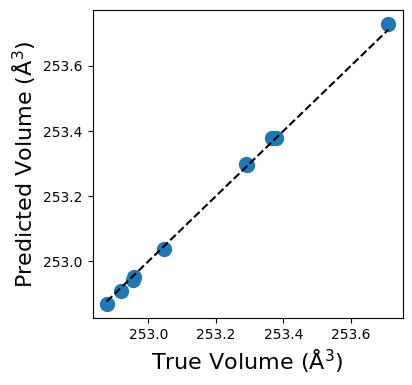

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(volume_true_list, volume_pred_list, 'o', ms=10)
fsize=16
ax.set_xlabel(r'True Volume ($\mathrm{\AA}^3$)', fontsize=fsize)
ax.set_ylabel(r'Predicted Volume ($\mathrm{\AA}^3$)', fontsize=fsize)
ax.plot([min(volume_true_list), max(volume_true_list)], [min(volume_true_list), max(volume_true_list)], 'k--')
plt.show()